# Applying noise to custom unitary gates

## Introduction

This notebook shows how to add custom unitary gates to a quantum circuit, and use them for noise simulations in Qiskit Aer.

In [1]:
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error

from qiskit.tools.visualization import plot_histogram

## Creating matrix operators

We can use the `Operator` class in `qiskit.quantum_info` to represent arbitrary matrix operators. If the operator is unitary it can then be added to a quantum circuit and used for simulation on Qiskit Aer.

Lets create two operators below for a CNOT gate and an iSWAP gate:

$$\mbox{CNOT} = \left(\begin{array} 
& 1 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & 0 & 1 & 0 \\ 
0 & 1 & 0 & 0
\end{array}\right), \quad
\mbox{iSWAP} = \left(\begin{array} 
& 1 & 0 & 0 & 0 \\ 
0 & 0 & i & 0 \\ 
0 & i & 0 & 0 \\ 
0 & 0 & 0 & 1
\end{array}\right)$$


In [2]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = Operator([[1, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = Operator([[1, 0, 0, 0],
                     [0, 0, 1j, 0],
                     [0, 1j, 0, 0],
                     [0, 0, 0, 1]])

**Note:** The matrix is specified with respect to the tensor product $U_{b}\otimes U_{a}$ for qubits specified by list `[a, b]`.

## Using operators in circuits

Let us demonstrate how these can be used in a circuit. We will consider an example of implementing a CNOT gate decomposed in terms of single-qubit gates and the iSWAP gate as follows.

In [3]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2)

# Add gates
cx_circ.sdg(1)
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)

print(cx_circ)

     ┌─────┐     ┌────────┐┌─────┐┌───┐┌─────┐┌────────┐     
q_0: ┤ SDG ├─────┤0       ├┤ SDG ├┤ H ├┤ SDG ├┤0       ├─────
     ├─────┤┌───┐│  iswap │└─────┘└───┘└─────┘│  iswap │┌───┐
q_1: ┤ SDG ├┤ H ├┤1       ├───────────────────┤1       ├┤ S ├
     └─────┘└───┘└────────┘                   └────────┘└───┘


Note that we have assigned an optional *label* of `"iswap"` to the unitary when it is inserted. This allows us to identify this unitary in a Qiskit Aer `NoiseModel` so that we can add errors to these custom unitary gates in noisy circuit simulations.

We can confirm this circuit returns the correct output using the `Operator` class as a simulator for the circuit:

In [4]:
# Simulate the unitary for the circuit using Operator:
unitary = Operator(cx_circ)
print(unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


And to confirm the output is correct we can compute the average gate fidelity:

In [5]:
f_ave = average_gate_fidelity(cx_op, unitary)
print("Average Gate Fidelity: F = {:f}".format(f_ave))

Average Gate Fidelity: F = 1.000000


## Creating a custom unitary in a noise model

The Qiskit Aer `QasmSimulator` supports simulation of arbitrary unitary operators directly as specified by the `"unitary"` in the basis gates.

In [6]:
'unitary' in QasmSimulator().configuration().basis_gates

True

This allows us to add noise models to arbitrary unitaries in our simulation when we identify them using the optional `label` argument of `QuantumCircuit.unitary`.

We will now do this by creating a `NoiseModel` that includes a quantum error channel on our custom iSWAP gate. For our example we will create a 2-qubit error consisting of two single-qubit amplitude damping channels with different damping parameters. For now we will assume all the other circuit instructions are ideal.

In [7]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0)
qerror_q1 = amplitude_damping_error(param_q1)
iswap_error = qerror_q1.tensor(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

Note that when we add an error to a custom label such as `"iswap"` the `NoiseModel` does not know what gate this label is supposed to apply to, so we must manually add the desired gate string to the noise model `basis_gates`. This ensures that the compiler will unroll to the correct basis gates for the noise model simulation. This can done using the `NoiseModel.add_basis_gates` function:

In [8]:
noise_model.add_basis_gates(['unitary'])
print(noise_model.basis_gates)

['cx', 'id', 'u3', 'unitary']


By default the basis gates of a noise model are `['cx','id','u3']` plus any standard `QasmSimulator` basis gates that are added to the noise model.

## Simulating a custom unitary noise model

Let us first take our previous CX circuit and add an initial Hadamard gate and final measurement to create a Bell-state preparation circuit that we may simulator on the `QasmSimulator` both for the ideal and noisy case:

In [9]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ = bell_circ + cx_circ 
bell_circ.measure([0,1], [0,1])
print(bell_circ)

      ┌───┐ ┌─────┐┌────────┐┌─────┐┌───┐┌─────┐┌────────┐     ┌─┐   
q_0: ─┤ H ├─┤ SDG ├┤0       ├┤ SDG ├┤ H ├┤ SDG ├┤0       ├─────┤M├───
     ┌┴───┴┐└┬───┬┘│  iswap │└─────┘└───┘└─────┘│  iswap │┌───┐└╥┘┌─┐
q_1: ┤ SDG ├─┤ H ├─┤1       ├───────────────────┤1       ├┤ S ├─╫─┤M├
     └─────┘ └───┘ └────────┘                   └────────┘└───┘ ║ └╥┘
c_0: ═══════════════════════════════════════════════════════════╩══╬═
                                                                   ║ 
c_1: ══════════════════════════════════════════════════════════════╩═
                                                                     


### Ideal output

Let's first see the ideal output. Since this generates a Bell-state we expect two peaks for 00 and 11.

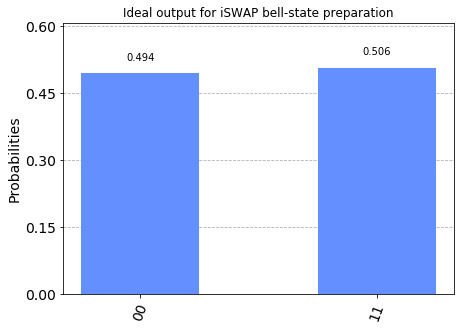

In [10]:
# Execute on the simulator without noise
job = execute(bell_circ, QasmSimulator(),
              basis_gates=noise_model.basis_gates)
ideal_result = job.result()
ideal_counts = ideal_result.get_counts(bell_circ)
plot_histogram(ideal_counts, title='Ideal output for iSWAP bell-state preparation')

### Noisy circuit execution

Finally, let's now simulate it with our custom noise model. Since there is a small amplitude damping error on the two-qubit gates we expect small additional peaks for the 01 and 10 outcome probabilities.

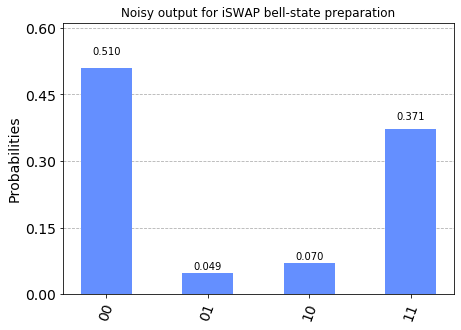

In [11]:
# Execute on the simulator without noise
job = execute(bell_circ, QasmSimulator(),
              basis_gates=noise_model.basis_gates,
              noise_model=noise_model)
noise_result = job.result()
noise_counts = noise_result.get_counts(bell_circ)
plot_histogram(noise_counts, title='Noisy output for iSWAP bell-state preparation')

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright